### Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from string import ascii_letters
import numpy as np
import matplotlib.pyplot as plt
from torchtext.datasets import WikiText103
import time
import copy
%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import re

### Mount data 
# ***The path to the Spanish data will have to be changed for another setup***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
spanish_path = "/content/drive/MyDrive/dlstems/mini_sbwce.clean.txt"

Mounted at /content/drive


### Make a dataset to process and return data from our different sources: Spanish text doc and Pytorch Wiki103 dataset:

In [ ]:
class processedWiki(torch.utils.data.Dataset):
  '''
  Custom Dataset class for Language RNN training
  Inputs: 
  inputData: a list containing an iterable for each language
  set_size: The amount of total characters to use from each language
  chunkSize: The sequence length of data samples
  '''
  
  def __init__(self, inputData, set_size, chunkSize):
    #Make a set of allowed characters. This is periods, spaces, and lower case letters used in both languages
    allowed = set('aábcdeéfghiíjklmnñoópqrstuúüvwxyz .')
    #Make a buffer for holding data
    language_samples = []
    #For each language in the input data:
    for language in inputData:
      #Make a string to hold the characters
      languageText = ''
      #Iterate through the iterable for the language
      for token in language:
        #Process each token. Remove <unk> characters
        token.replace("<unk>", "")
        #Make lowercase
        #Remove characters that arent in allowed
        token = ''.join(l for l in token if l in allowed)
        #Add it to the string
        languageText = languageText + token

      #Process the string to remove excess whitespace
      languageText = re.sub(" +" , " ", languageText)
      #Remove spaces before periods also
      languageText = re.sub(r' +([?.!"])', r'\1', languageText)
      #Add set_size chars to the language samples
      language_samples.append(languageText[0:set_size])


    #Make a vocabulary of all appearing chars
    self.vocab = dict([(y,x+1) for x,y in enumerate(sorted(set(" ".join(language_samples))))])
    labels = []

    chunks = []


    #Iterate through the language samples
    for l in range(0, len(language_samples)):
      count = chunkSize
      #Split each string into chunks(training samples) and assign labels based on the source language
      while count<=len(language_samples[l]):
        processed_text = language_samples[l][count-chunkSize:count]
        processed_text = [self.vocab[x] for x in processed_text]
        chunks.append(processed_text)
        labels.append(l)
        count +=chunkSize
    
    #Save the data and labels
    self.tokens = np.array(chunks)
    self.labels = np.array(labels)


  def __len__(self):
    #Return the number of data samples
    return len(self.tokens)

  def __getitem__(self, index):
    #Return a sample and its label
    return self.tokens[index], self.labels[index]

In [ ]:
#How many characters from each language to use
train_set_len = 30000
#Sequence length
chunk_size = 100
#Sequences per batch
batch_size = 32

#Use the test set from wikiText. Test set is used since it is plenty large and is faster to load than train
_, english_text, _ = WikiText103()


#Put the raw spanish text into an iterable. Also replace newlines with periods
spanish_text = []
spanish_raw = (open(spanish_path).read())[0:2*train_set_len].replace("\n", ". ")
spanish_text.append(spanish_raw)

#Make a dataset from the two sources
text_dataset = processedWiki([english_text, spanish_text], train_set_len, chunk_size)

#Declare lengths of train, test, valid sets
train_len = int(len(text_dataset) * 0.6)
test_len = int(len(text_dataset) * 0.2)
validation_len = len(text_dataset)-(train_len+test_len)

#Split the dataset
train_set, val_set, test_set = torch.utils.data.random_split(text_dataset, [train_len, validation_len, test_len])

#Make dataloaders
train_DL = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_DL = DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_DL = DataLoader(val_set, batch_size=batch_size, shuffle=True)

wikitext-103-v1.zip: 100%|██████████| 190M/190M [00:14<00:00, 13.3MB/s]


FileNotFoundError: ignored

### Check a sample for the data. Should be 100 characters where each character is a number

In [ ]:
test, test_label = [x for x in iter(train_DL).next()]

print("Example 100 characters\n")
print(test[0])
print(test_label[0])


### Train RNN

### Declare an RNN model

In [ ]:

class myRNN(nn.Module):
  #Initialize the model
  def __init__ (self, dict_size, embed_size, hidden_size, num_layers = 1, num_classes = 2):
    super(myRNN, self).__init__()
    #Three layers: Embedding, RNN, and output
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.RNN(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers)
    self.out = nn.Linear(hidden_size, num_classes)

  def forward(self, input):
    #Pass through emved
    embeddings = self.embed(input)
    #Permute the embeddings
    embed_swap = torch.permute(embeddings, (1,0,2))
    #Pass through RNN
    rnn_out, rnn_hidden = self.rnn(embed_swap)
    #Take last element
    rnn_last_out = rnn_out[-1]
    #Get scores with output
    fc_out = self.out(rnn_last_out)
    scores = F.log_softmax(fc_out, dim = 1)

    return scores

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, verbose =True):
  '''Function for training a model
  Inputs: model to train
          dataloaders for val and train
          criterion for loss
          optimizer for adjusting weights
          number of epochs optional
          verbose=True includes more print statements'''

    train_since = time.time()
    losses = []
    valLosses = []
    minimal_loss = 1e10
    size = dict()

    #Iterate through dataloaders and find their sizes
    for i in dataloaders:
      size[i] = len(dataloaders[i].dataset)
    for epoch in range(num_epochs):
        since = time.time()
        if verbose:
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if phase == 'train':
                    optimizer.zero_grad()  # zero the parameter gradients
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / size[phase]      
            if verbose:   
              print('{} Loss: {:.6f} Time: {:.4f}s'.format(phase, epoch_loss, time.time()-since))
            if phase == 'train':
              losses.append(epoch_loss)   
            if phase == 'val':
                valLosses.append(epoch_loss)
                if epoch > 0 and minimal_loss > epoch_loss:
                    minimal_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

    #Save best weights
    model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - train_since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Minimal Loss: {:6f}'.format(minimal_loss))
    model.load_state_dict(best_model_wts)
    

    return model, model_wts, best_model_wts, losses, valLosses

### Train an RNN model with the trainloop

In [ ]:
#Declare the model
model = myRNN(len(text_dataset.vocab)+1, 100, 200)
#Declare the loss function criterion
criterion = nn.CrossEntropyLoss()
#Declare the number of epochs
num_epochs = 100
#Declare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=5e-6)


# Move model and loss function to GPU
if torch.cuda.is_available(): 
  criterion = criterion.cuda()
  model = model.cuda()

#Make a dictionary for the train loop
loader_set = dict()
loader_set['train'] = train_DL
loader_set['val'] = val_DL

#Run training!
model, model_wts, best_model_wts, losses, valLosses = train_model(model,loader_set, criterion, optimizer, num_epochs)

In [ ]:
"""
Function: Plot losses of a trained model
Inputs: val_loss: list of validation losses
        train_loss: list of test set losses

        
Outputs: N/a
"""
def plotLosses(val_loss, train_loss, title = None, valid_accuracy = False):
    #Setup subplots
    plt.figure(figsize = (10,10))
    ax2 = plt.subplot(2,1,2)
    #Label plots
    ax2.plot(val_loss, label = 'Validation loss')
    ax2.plot(train_loss, label = 'Train loss')
    if valid_accuracy != False:
      ax1 = plt.subplot(2,1,1)
      ax1.plot(valid_accuracy, label = 'Validation Accuracy')
      ax1.set_xlabel("Iteration")
      ax1.set_ylabel("Validation Accuracy")
      ax1.legend()
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Loss per Sample")
    if title !=None:
      ax2.set_title(title)
    ax2.legend()
    plt.show()

In [ ]:
#Call the plotting function
plotLosses(valLosses, losses)


#Test model on the test dataset:
test, test_label = [x for x in iter(test_DL).next()]
test = test.cuda()
output = model(test)
output = output.detach().cpu().numpy()
print("Predictions and labels for a random test batch")
print(np.exp(output))
print(test_label)

### Experiment. I 

Hidden size = 1
Training complete in 0m 17s
Minimal Loss: 1.030663
Hidden size = 2
Training complete in 0m 17s
Minimal Loss: 0.746346
Hidden size = 20
Training complete in 0m 18s
Minimal Loss: 0.680363
Hidden size = 40
Training complete in 0m 18s
Minimal Loss: 0.701707
Hidden size = 80
Training complete in 0m 19s
Minimal Loss: 0.638575
Hidden size = 120
Training complete in 0m 20s
Minimal Loss: 0.637864
Hidden size = 160
Training complete in 0m 21s
Minimal Loss: 0.567456
Hidden size = 200
Training complete in 0m 24s
Minimal Loss: 0.097387
Hidden size = 350
Training complete in 0m 24s
Minimal Loss: 0.022959
Hidden size = 500
Training complete in 0m 24s
Minimal Loss: 0.019751
Hidden size = 1000
Training complete in 0m 47s
Minimal Loss: 0.025494
Hidden size = 2000
Training complete in 1m 48s
Minimal Loss: 0.020663


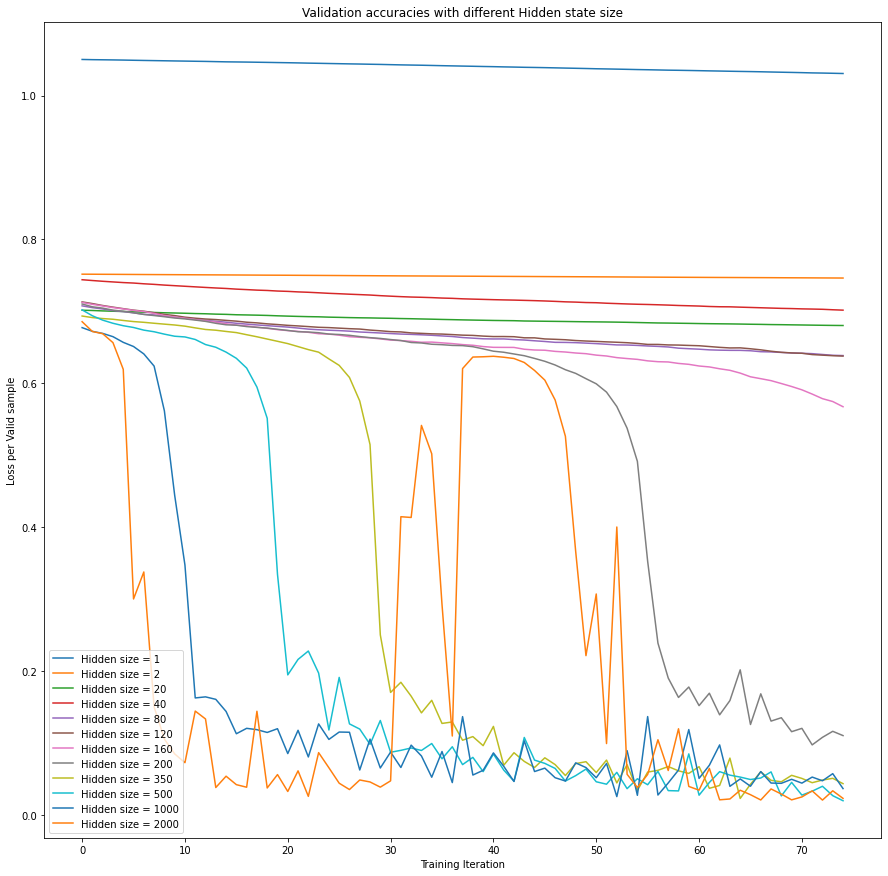

In [ ]:
hidden_sizes = [1,2,20,40,80, 120, 160, 200, 350, 500, 1000, 2000]
lossesBuffer = []
plt.figure(figsize=(15,15))
for h in hidden_sizes:
  title = "Hidden size = " + str(h)
  print(title)
  e_model = myRNN(len(text_dataset.vocab)+1, 100, h)
  criterion = nn.CrossEntropyLoss()
  num_epochs = 75
  optimizer = torch.optim.Adam(e_model.parameters(), lr=2e-5, weight_decay=5e-6)
  # Move model and loss function to GPU
  if torch.cuda.is_available(): 
    criterion = criterion.cuda()
    e_model = e_model.cuda()
  loader_set = dict()
  loader_set['train'] = train_DL
  loader_set['val'] = val_DL

  e_model, e_model_wts, e_best_model_wts, losses, valLosses = train_model(e_model,loader_set, criterion, optimizer, num_epochs, False)
  
  plt.plot(valLosses, label = title)

plt.title("Validation accuracies with different Hidden state size")
plt.legend()
plt.xlabel("Training Iteration")
plt.ylabel("Loss per Valid sample")
plt.show()


Layer num = 1
Training complete in 0m 22s
Minimal Loss: 0.152263
Layer num = 2
Training complete in 0m 22s
Minimal Loss: 0.041912
Layer num = 3
Training complete in 0m 26s
Minimal Loss: 0.010854
Layer num = 4
Training complete in 0m 31s
Minimal Loss: 0.003513
Layer num = 5
Training complete in 0m 36s
Minimal Loss: 0.018781
Layer num = 10
Training complete in 1m 8s
Minimal Loss: 0.000873


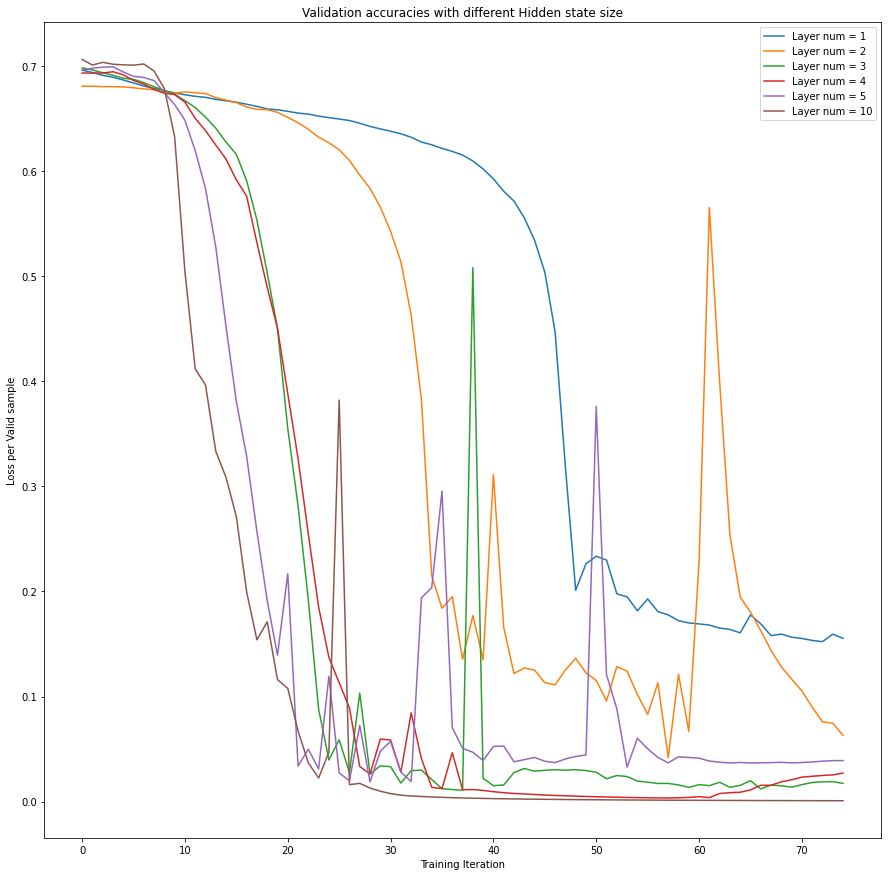

In [ ]:
RNN_layers = [1,2,3,4,5,10]
cre
for l in RNN_layers:
  title = "Layer num = " + str(l)
  print(title)
  e_model = myRNN(len(text_dataset.vocab)+1, 100, 200, l)
  criterion = nn.CrossEntropyLoss()
  num_epochs = 75
  optimizer = torch.optim.Adam(e_model.parameters(), lr=2e-5, weight_decay=5e-6)
  # Move model and loss function to GPU
  if torch.cuda.is_available(): 
    criterion = criterion.cuda()
    e_model = e_model.cuda()
  loader_set = dict()
  loader_set['train'] = train_DL
  loader_set['val'] = val_DL

  e_model, e_model_wts, e_best_model_wts, losses, valLosses = train_model(e_model,loader_set, criterion, optimizer, num_epochs, verbose = False)
  
  plt.plot(valLosses, label = title)

plt.title("Validation accuracies with different Hidden state size")
plt.legend()
plt.xlabel("Training Iteration")
plt.ylabel("Loss per Valid sample")
plt.show()

### Intuition

In [ ]:
i_test = "áéíóúñü"

#Ideas to test:
#Common words in each language
#Letters unique to Spanish
#Words that don't seem unique in any way

intuition_tests = [#Articles
                   "is",
                   "es",
                   "el",
                   "un",
                   "the",
                   "as",
                   "que",

                   #Spanish only letters
                   "á",
                   "é",
                   "ü",
                   "ñ",
                   #Random words
                   "apple",
                   "binoculars",
                   "vamonos",
                   "escuela",
                   #Sentences
                   "this is the sample sentence in english for predicting outputs",
                   #Same thing without articles
                   "sample sentence in english predicting outputs",
                      
                 

                   
                   ]
for i_test in intuition_tests:
  word = i_test
  i_test =  np.array([text_dataset.vocab[x] for x in i_test]).reshape((1, -1))
  i_test = torch.from_numpy(i_test).cuda()
  output = model(i_test)
  output = output.detach().cpu().numpy()
  print(word)
  print(np.exp(output))
  print()


is
[[0.5382797  0.46172032]]

es
[[0.29869503 0.701305  ]]

el
[[0.2486869 0.7513131]]

un
[[0.50818855 0.49181148]]

the
[[0.97478306 0.0252169 ]]

as
[[0.3418319  0.65816814]]

que
[[0.19261761 0.80738235]]

á
[[0.39014637 0.60985357]]

é
[[0.5999049  0.40009508]]

ü
[[0.63400245 0.36599755]]

ñ
[[0.54154533 0.45845473]]

apple
[[0.8202641  0.17973587]]

binoculars
[[0.64797443 0.35202563]]

vamonos
[[0.73702437 0.26297563]]

escuela
[[0.01946542 0.9805347 ]]

this is the sample sentence in english for predicting outputs
[[0.98973954 0.01026043]]

sample sentence in english predicting outputs
[[0.989705   0.01029504]]



### Part 2

In [ ]:
class s_myRNN(nn.Module):
  def __init__ (self, dict_size, embed_size, hidden_size, num_layers = 1, num_classes = 2):
    super(s_myRNN, self).__init__()
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.RNN(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers)
    self.out = nn.Linear(hidden_size, num_classes)

  def forward(self, input, outlayer = -1):
    embeddings = self.embed(input)
    embed_swap = torch.permute(embeddings, (1,0,2))
    rnn_out, rnn_hidden = self.rnn(embed_swap)
    if outlayer == -1:
      rnn_last_out = rnn_out[outlayer]
    else:
      temp = []
      for x in range(len(outlayer)):
        temp.append(rnn_out[outlayer[x]-1, x, :])
      rnn_last_out = torch.stack(temp, dim=0)
    fc_out = self.out(rnn_last_out)
    scores = F.log_softmax(fc_out, dim = 1)

    return scores

In [ ]:
def languageParse(language, set_size):
  allowed = set('aábcdeéfghiíjklmnñoópqrstuúüvwxyz .')
  temp = []
  text = ""
  for token in language:
    token.replace("unk", "")
    token = token.lower()
    token = ''.join(l for l in token if l in allowed)
    text = text + token
  text = re.sub(" +" , " ", text)
  text = re.sub(r' +([?.!"])', r'\1', text)
  sentences = text.split(".")
  
  longest_string = max(sentences, key=len)

  for sentence in sentences:
    if len(sentence)>1:
      temp.append(sentence)
    if len(temp) == set_size:
      return temp

In [ ]:
class sentenceProcessedWiki(torch.utils.data.Dataset):
  '''
  Custom Dataset class for mnist autoencoder training
  '''
  
  def __init__(self, inputData, set_size):
    #make a list of images as the datastructure
    language_samples = []
    chars = ""
    for language in inputData:
      temp = languageParse(language, set_size)
      language_samples.append(temp)
      chars = chars +(" ".join(temp))
    self.vocab = dict([(y,x+1) for x,y in enumerate(sorted(set(chars)))])
    labels = []
    padded_sentences = []
    
    for l in range(0, len(language_samples)):
      for x in range(len(language_samples[l])):
        processed_text = torch.from_numpy(np.array([self.vocab[i] for i in language_samples[l][x]]))
        padded_sentences.append(processed_text)
        labels.append(l)
    
    language_samples = sum(language_samples, [])
    self.tokens = padded_sentences
    self.labels = np.array(labels)

  def __len__(self):
    return len(self.tokens)

  def __getitem__(self, index):
    #When an image is retrieved, return a copy of it as the label as well
    return self.tokens[index].reshape(-1), self.labels[index]

In [ ]:
from torch.nn.utils.rnn import pad_sequence
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  outs = [len(x) for x in xx]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=1)

  return xx_pad, torch.from_numpy(np.array(yy)), outs

In [ ]:
#How many sentences from each language to use
train_set_sentences = 500

#Sequences per batch
batch_size = 32

_, english_text, _ = WikiText103()
spanish_text = []

spanish_raw = (open(spanish_path).read())[0:300000].replace("\n", ". ")
spanish_text.append(spanish_raw)

text_dataset = sentenceProcessedWiki([english_text, spanish_text], train_set_sentences)

train_len = int(len(text_dataset) * 0.6)
test_len = int(len(text_dataset) * 0.2)
validation_len = len(text_dataset)-(train_len+test_len)

train_set, val_set, test_set = torch.utils.data.random_split(text_dataset, [train_len, validation_len, test_len])

train_DL = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
test_DL =DataLoader(test_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_DL = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [ ]:
test, test_label, outlayers = [x for x in iter(val_DL).next()]

print("Example sentence \n")
print(test)
print(test.shape)
print(test_label)
print(outlayers)

Example sentence 

tensor([[ 1, 15, 16,  ...,  1,  1,  1],
        [ 1,  7, 21,  ...,  1,  1,  1],
        [ 1, 21,  9,  ...,  1,  1,  1],
        ...,
        [ 1,  5, 16,  ...,  1,  1,  1],
        [ 1, 21,  9,  ...,  1,  1,  1],
        [ 1,  2, 13,  ...,  1,  1,  1]])
torch.Size([32, 1016])
tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1])
[3, 4, 116, 49, 99, 103, 169, 50, 71, 75, 111, 31, 48, 146, 36, 133, 144, 52, 124, 83, 169, 2, 140, 90, 164, 74, 52, 37, 1016, 45, 149, 49]


In [ ]:
def train_model2(model, dataloaders, criterion, optimizer, num_epochs=25, verbose =True):
    train_since = time.time()
    
    losses = []
    valLosses = []
    minimal_loss = 1e10
    size = dict()
    for i in dataloaders:
      size[i] = len(dataloaders[i].dataset)
    for epoch in range(num_epochs):
        since = time.time()
        if verbose:
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            
            
            # Iterate over data.
            for inputs, labels, outlayers in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if phase == 'train':
                    optimizer.zero_grad()  # zero the parameter gradients
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    optimizer.zero_grad()
                    outputs = model(inputs, outlayers)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / size[phase]      
            if verbose:   
              print('{} Loss: {:.6f} Time: {:.4f}s'.format(phase, epoch_loss, time.time()-since))
            if phase == 'train':
              losses.append(epoch_loss)   
            if phase == 'val':
                valLosses.append(epoch_loss)
                if epoch > 0 and minimal_loss > epoch_loss:
                    minimal_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

    model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - train_since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Minimal Loss: {:6f}'.format(minimal_loss))
    model.load_state_dict(best_model_wts)
    return model, model_wts, best_model_wts, losses, valLosses

In [ ]:
s_model = s_myRNN(len(text_dataset.vocab)+1, 100, 300, 4)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
optimizer = torch.optim.Adam(s_model.parameters(), lr=3e-5, weight_decay=5e-6)
# Move model and loss function to GPU
if True: 
  criterion = criterion.cuda()
  s_model = s_model.cuda()
loader_set = dict()
loader_set['train'] = train_DL
loader_set['val'] = val_DL

s_model, s_model_wts, best_model_wts, losses, valLosses = train_model2(s_model,loader_set, criterion, optimizer, num_epochs)

Epoch 0/29
----------
train Loss: 0.676301 Time: 1.7951s
val Loss: 0.650298 Time: 2.0644s
Epoch 1/29
----------
train Loss: 0.629485 Time: 1.6554s
val Loss: 0.615358 Time: 1.9336s
Epoch 2/29
----------
train Loss: 0.584118 Time: 1.6338s
val Loss: 0.573186 Time: 1.8987s
Epoch 3/29
----------
train Loss: 0.540633 Time: 1.5900s
val Loss: 0.539231 Time: 1.8638s
Epoch 4/29
----------
train Loss: 0.498340 Time: 1.6218s
val Loss: 0.503503 Time: 1.8903s
Epoch 5/29
----------
train Loss: 0.463221 Time: 1.6549s
val Loss: 0.462110 Time: 1.9177s
Epoch 6/29
----------
train Loss: 0.424673 Time: 1.6609s
val Loss: 0.421982 Time: 1.9345s
Epoch 7/29
----------
train Loss: 0.367973 Time: 1.6505s
val Loss: 0.335379 Time: 1.9293s
Epoch 8/29
----------
train Loss: 0.275902 Time: 1.6156s
val Loss: 0.161205 Time: 1.9021s
Epoch 9/29
----------
train Loss: 0.144485 Time: 1.6291s
val Loss: 0.078259 Time: 1.8951s
Epoch 10/29
----------
train Loss: 0.137750 Time: 1.6270s
val Loss: 0.081818 Time: 1.8929s
Epoch 11/

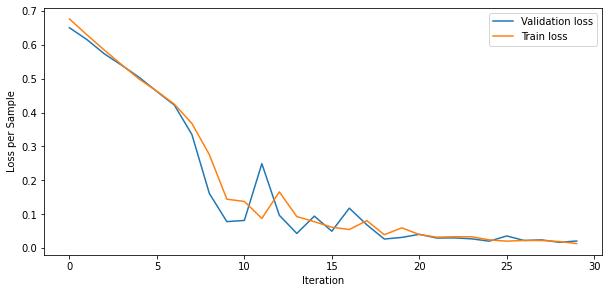

Predictions and labels for a random test batch
60
tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0])


In [ ]:
plotLosses(valLosses, losses)
test, test_label, i = [x for x in iter(test_DL).next()]
test = test.cuda()
output = s_model(test, i)
output = output.detach().cpu().numpy()
print("Predictions and labels for a random test batch")
print(np.argmax(np.exp(output)))
print(test_label)